<a href="https://colab.research.google.com/github/Shrey-Viradiya/DiveDeep/blob/master/Prac8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation Using UNet Like architecture

### 18BCE259

In [1]:
!nvidia-smi

Sun Apr 18 10:57:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!gdown --id 0B0d9ZiqAgFkiOHR1NTJhWVJMNEU
!unzip -q "/content/dataset1.zip"

Downloading...
From: https://drive.google.com/uc?id=0B0d9ZiqAgFkiOHR1NTJhWVJMNEU
To: /content/dataset1.zip
126MB [00:00, 188MB/s]


### Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf

### HyperParameters

In [2]:
batch_size = 2
epochs = 5
num_classes = 12
images_train_directory = "/content/dataset1/images_train"
annotations_train_directory = "/content/dataset1/annotations_train"
images_test_directory = "/content/dataset1/images_test"
annotations_test_directory = "/content/dataset1/annotations_test"

### Get Model

In [3]:
def UNet_VGGencoder():
    vgg = tf.keras.applications.VGG16(include_top = False, weights='imagenet', input_shape=(360, 480, 3))
    print("VGG Summary\n","="*100)
    vgg.summary()

    input_layer = vgg.input
    output_layer = vgg.layers[-6].output

    encoder = tf.keras.models.Model(input_layer, output_layer)

    for layer in encoder.layers:
        layer.trainable = False

    print("\n\nVGGencoder Summary\n","="*100)
    encoder.summary()

    lastPooling = tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same')(output_layer)
    center = tf.keras.layers.Conv2D(1024, (3,3), activation='relu', padding ='same')(lastPooling)
    center = tf.keras.layers.Conv2D(1024, (3,3), activation='relu', padding ='same')(center)
    center = tf.keras.layers.BatchNormalization()(center)

    up4 = tf.keras.layers.UpSampling2D((2,2))(center)
    up4 = tf.keras.layers.Conv2D(512, (2,2), activation='relu', padding='same')(up4)
    up4 = tf.keras.layers.Lambda(lambda x: x[:,0:45,:,:])(up4)
    up4 = tf.keras.layers.concatenate([up4, encoder.get_layer(name = 'block4_conv3').output], axis = 3)
    up4 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding ='same')(up4)
    up4 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding ='same')(up4)
    up4 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding ='same')(up4)
    up4 = tf.keras.layers.BatchNormalization()(up4)

    up3 = tf.keras.layers.UpSampling2D((2,2))(up4)
    up3 = tf.keras.layers.Conv2D(256, (2,2), activation='relu', padding='same')(up3)
    up3 = tf.keras.layers.concatenate([up3, encoder.get_layer(name = 'block3_conv3').output], axis = 3)
    up3 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding ='same')(up3)
    up3 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding ='same')(up3)
    up3 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding ='same')(up3)
    up3 = tf.keras.layers.BatchNormalization()(up3)

    up2 = tf.keras.layers.UpSampling2D((2,2))(up3)
    up2 = tf.keras.layers.Conv2D(128, (2,2), activation='relu', padding='same')(up2)
    up2 = tf.keras.layers.concatenate([up2, encoder.get_layer(name = 'block2_conv2').output], axis = 3)
    up2 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding ='same')(up2)
    up2 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding ='same')(up2)
    up2 = tf.keras.layers.BatchNormalization()(up2)

    up1 = tf.keras.layers.UpSampling2D((2,2))(up2)
    up1 = tf.keras.layers.Conv2D(64, (2,2), activation='relu', padding='same')(up1)
    up1 = tf.keras.layers.concatenate([up1, encoder.get_layer(name = 'block1_conv2').output], axis = 3)
    up1 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding ='same')(up1)
    up1 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding ='same')(up1)
    up1 = tf.keras.layers.Conv2D(num_classes, (1,1), activation='softmax', padding ='same')(up1)

    model = tf.keras.models.Model(inputs = input_layer, outputs = up1)

    print("\n\nVGGencoderDecoder Summary\n","="*100)
    model.summary()
    return model

### Generators

In [4]:
def train_gen(images_train_directory, annotations_train_directory):
    image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
    mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

    image_batch = image_datagen.flow_from_directory(
        directory = images_train_directory,
        class_mode = None,
        target_size = (360,480),
        shuffle = False,
        seed = 259,
        batch_size = batch_size,
        color_mode = 'rgb'
    )

    mask_batch = mask_datagen.flow_from_directory(
        directory = annotations_train_directory,
        class_mode = None,
        target_size = (360,480),
        shuffle = False,
        seed = 259,
        batch_size = batch_size,
        color_mode = 'grayscale'
    )

    combined_gen = zip(image_batch, mask_batch)

    for (i,j) in combined_gen:
        new_mask = np.zeros(shape=(j.shape[0], j.shape[1], j.shape[2], num_classes))
        for k in range(j.shape[0]):
            mask = j[k]
            for m in range(num_classes):
                new_mask[k,:,:,m] = mask[:,:,0] == m
        yield (i,new_mask)

In [5]:
def test_gen(images_test_directory):
    image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

    image_batch = image_datagen.flow_from_directory(
        directory = images_test_directory,
        class_mode = None,
        target_size = (360,480),
        shuffle = False,
        seed = 259,
        batch_size = batch_size,
        color_mode = 'rgb'
    )

    for i in image_batch:
        yield i

### Model creating, compiling, training and prediction

In [6]:
model = UNet_VGGencoder()
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4),
              loss = "categorical_crossentropy",
              metrics = ['accuracy'])
model.fit(train_gen(images_train_directory, annotations_train_directory), steps_per_epoch = 400, epochs = epochs, validation_data=train_gen(images_test_directory, annotations_test_directory), validation_steps=51)
results = model.predict(test_gen(images_test_directory), steps = 51)

VGG Summary
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 90, 120, 128)

In [7]:
results.shape

(101, 360, 480, 12)

In [8]:
tf.keras.backend.argmax(results[0], axis = 2).shape

TensorShape([360, 480])

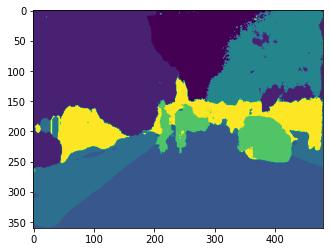

In [9]:
import matplotlib.pyplot as plt
plt.imshow(tf.keras.backend.argmax(results[0], axis = 2))

In [10]:
# import cv2
# im = cv2.imread("/content/dataset1/images_prepped_train/0001TP_006690.png", 1)
# im.shape

In [11]:
# !rm -rf dataset1 dataset1.zip